
### 1. Introducción

El Ejercicio 1 del TP3 tiene como objetivo tomar una imagen como entrada, aplicarle el algoritmo escala de imagen, y mostrar la imagen transformada.

El algoritmo "Escala de Imagen" se encarga de reducir el tamaño de la imagen. Su funcionamiento consiste en que cada píxel de salida se reemplaza por su píxel más cercano en la entrada. Se redondean las coordenadas a su entero más cercano. 

Vamos a ejecutar el algoritmo de manera secuencial, haciendo uso de la CPU; y luego haciendo uso de la GPU, con CUDA, realizando una ejecución paralela mediante threads. Una vez ejecutada la función en ambos casos, se mostrará la imagen mediante un plot.

### 2. Armado del ambiente


In [1]:
#INSTALACION DE BIBLIOTECA 'PYCUDA'#
!pip install pycuda

In [2]:
!pip install validators

In [3]:
#--------------------------------------BIBLIOTECAS--------------------------------------#
import numpy as np
import validators
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
#-----------------------------------PARAMETRO IMAGEN------------------------------------#
#@title Ingrese la url de una imagen:
url_imagen = "https://wallpaperaccess.com/full/4910986.jpg" #@param {type: "string" }

#Verificacion de que el usuario haya ingresado una URL de imagen valida
if(url_imagen == "" or not validators.url(url_imagen)):
  raise TypeError("Debe ingresar la url de una imagen.")

!wget {url_imagen} -O imagen.jpg

--2021-11-13 15:40:12--  https://wallpaperaccess.com/full/4910986.jpg
Resolving wallpaperaccess.com (wallpaperaccess.com)... 104.22.33.65, 104.22.32.65, 172.67.7.204, ...
Connecting to wallpaperaccess.com (wallpaperaccess.com)|104.22.33.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 670190 (654K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 654.48K  --.-KB/s    in 0.06s   

2021-11-13 15:40:12 (11.3 MB/s) - ‘imagen.jpg’ saved [670190/670190]



### 3. Desarrollo
### CPU


Tiempo total de ejecucion:  1475.187 [ms]
Tiempo de procesamiento en CPU:  1261.9940000000001 [ms]


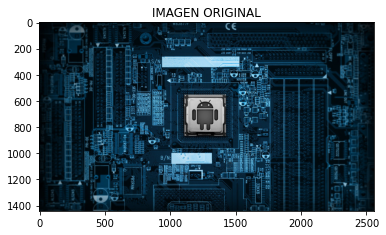

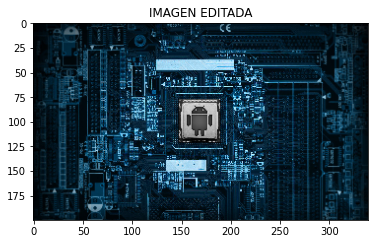

In [5]:
from datetime import datetime

#Obtencion del tiempo inicial
tiempo_total = datetime.now()

#Declaracion de funcion que realiza el pasaje del tiempo obtenido mediante datetime.now(), a milisegundos.
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

#---------------------------------------CODIGO--------------------------------------------#
# Importación de la imagen y obtencion de sus dimensiones 
imagen_normal = Image.open('imagen.jpg')
width, height = imagen_normal.size

#Ploteo de la imagen original
plt.figure()
plt.title("IMAGEN ORIGINAL")
imgplot=plt.imshow( imagen_normal )

# Creo una imagen vacia con los pixeles el ancho y el largo correspondiente
new_width, new_height = 340, 200
imagen_con_escala_nueva = Image.new(imagen_normal.mode, (new_width, new_height), 'white')

#Obtencion del tiempo previo a la ejecucion en GPU
tiempo_imagen_cpu = datetime.now()

# Declaro variables utiles para el algoritmo
scale_x = new_width/width
scale_y = new_height/height

# Lleno cada pixel de la imagen creada
for y in range(new_height):
    for x in range(new_width):
      x_nearest = int(np.round(x/scale_x))
      y_nearest = int(np.round(y/scale_y))
      pixel = imagen_normal.getpixel((x_nearest, y_nearest))
      imagen_con_escala_nueva.putpixel((x, y),  pixel)

# Guardo la imagen
imagen_con_escala_nueva.save('scaled_image.jpg')

#Calculo del tiempo total de procesamiento de la imagen en GPU
tiempo_imagen_cpu = datetime.now() - tiempo_imagen_cpu

#Ploteo de la imagen resultado
plt.figure()
plt.title("IMAGEN EDITADA")
imgplot=plt.imshow( imagen_con_escala_nueva )

#Calculo del tiempo total de ejecucion del programa
tiempo_total = datetime.now() - tiempo_total

print("Tiempo total de ejecucion: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo de procesamiento en CPU: ", tiempo_en_ms( tiempo_imagen_cpu   ), "[ms]" )

### GPU

Imagen del filtro: imagen.jpg -RGB- [1440, 2560]
Thread: [ 16 , 19  ], Bloque : [ 90 , 135 ]
Total de Thread: [ 1440 , 2565  ]  =  3693600
Tiempo TOTAL:  193.994 [ms]
Tiempo GPU  :  0.231 [ms]


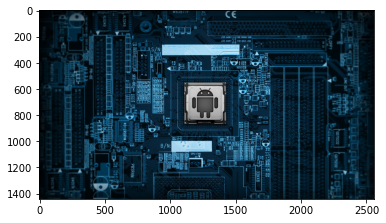

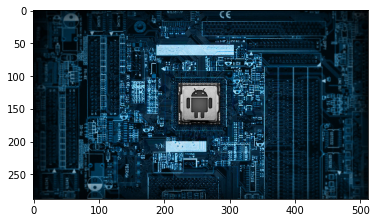

In [7]:
#--------------------------------------BIBLIOTECAS--------------------------------------#

from datetime import datetime

#Obtencion del tiempo inicial
tiempo_total = datetime.now()

import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()
import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule


# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_alto, img_ancho = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_R_cpu = numpy.empty_like( img_O_cpu)
# img_R_cpu = numpy.empty_like( img_O_cpu)
# img_R_cpu=img_R_cpu_[0:10000 ,0:1000]


# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )
# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, float escala, char *img_O, char *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  

  if(idx < ancho && idy < alto*escala)
  {

    // Calculo el color gris para el pixel a partir de los componentes.
    int aux=int(((idx+(idy*ancho)))/escala);
    img_R[(idx+(idy*ancho))*3  ]=img_O[aux*3];
    img_R[(((idx+(idy*ancho))*3)+1 ) ]=img_O[aux*3+1 ];
    img_R[(((idx+(idy*ancho))*3)+2)  ]=img_O[aux*3+2 ];
  }


}
""") 

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()
#@title ## 1 Parametros de ejecucion
#@markdown ---
#@markdown ### seleccione la escala de imagen:
escala = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}
kernel( numpy.int32(img_ancho), numpy.int32(img_alto), numpy.float32(escala),img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )


tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu[0:int(img_ancho*escala) ,0:int(img_alto*escala)] )
#imgplot=plt.imshow( img_R_cpu)

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )


4. Métricas

Se realizaron las siguientes mediciones:

Tiempo GPU | Tiempo CPU 
-------------------|------------------
2.01 ms      | 1187,46 ms
0,24 ms       | 1280 ms
 0,344 ms     | 1246,72 ms	 
0,29 ms       | 1244 ms
0,27 ms       | 1280 ms
0,26 ms       | 1252,26 ms
0,26 ms       | 1240,88 ms
0,25 ms       | 1248,30 ms
0,27 ms       | 1271 ms
0,26 ms       | 1262 ms

Tiempo promedio GPU |	Tiempo promedio CPU
-------------------|------------------
0.44 ms | 1251 ms

5. Conclusiones

Observando las metricas, podemos concluir que el procesamiento de la imagen en GPU se realiza más rapido que en CPU, en promedio 2.840 veces más rapido. Esto se debe a que en GPU se realizan operaciones de manera paralela mientras que en CPU se realizan las operaciones de manera secuencial. En cuanto a la eficacia del algortimo, en CPU es mayor que en GPU debido a la disminucion de la precision de los valores de los pixeles. Se podria mejorar la eficacia del filtro en GPU utilizando distintas dimensiones y valores en la matriz kernel. También, es más dificil de implementar el algoritmo en GPU.

6. Bibliografía

[1] Algoritmo de escala: 

Towards data science: https://towardsdatascience.com/image-processing-image-scaling-algorithms-ae29aaa6b36c

OpenCV: https://docs.opencv.org/4.4.0/da/d54/group__imgproc__transform.html#ga47a974309e9102f5f08231edc7e7529d


[3] Cuda - Documentación Oficial Nvidia:  https://docs.nvidia.com/cuda/

[4] Python basico UNLaM: https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb
